<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/image/ambulanze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

## Import librerie

In [49]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale

In [103]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/ambulanze/"

Mounted at /content/gdrive


In [ ]:
trainAV = pd.read_csv("gdrive/MyDrive/train.csv")
testAV = pd.read_csv("gdrive/MyDrive/test_vc2kHdQ.csv")

In [ ]:
print(len(trainAV) + len(testAV))

7290


In [ ]:
trainAV.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [ ]:
def add_class():
  for i, f in enumerate(sorted(os.listdir(base_dir))):
    if f.endswith('.jpg'):
      name = re.search(r'^(\d+)\.jpg$', f).group(1)

      a = plt.imread(base_dir + f)      
      fig = plt.figure(figsize=(4,4))
      ax = fig.add_subplot(111)

      ax.imshow(a)

      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)

      if f in trainAV['image_names'].values:
        label = trainAV.loc[trainAV['image_names'] == f]['emergency_or_not'].values[0] 

      elif f in testAV['image_names'].values:
        label = 2

      if int(label) == 0:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 1:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)

      elif int(label) == 2:
          fig.savefig("gdrive/MyDrive/emergency_models/class_test/{}.jpg".format(name), dpi = 100, bbox_inches = 'tight',
    pad_inches = 0)
    plt.close("all")
    print("Completato il: ", round(i/7290*100,2), "% dei file")

In [ ]:
add_class()

Output streaming troncato alle ultime 5000 righe.
Completato il:  31.43 % dei file
Completato il:  31.44 % dei file
Completato il:  31.45 % dei file
Completato il:  31.47 % dei file
Completato il:  31.48 % dei file
Completato il:  31.5 % dei file
Completato il:  31.51 % dei file
Completato il:  31.52 % dei file
Completato il:  31.54 % dei file
Completato il:  31.55 % dei file
Completato il:  31.56 % dei file
Completato il:  31.58 % dei file
Completato il:  31.59 % dei file
Completato il:  31.6 % dei file
Completato il:  31.62 % dei file
Completato il:  31.63 % dei file
Completato il:  31.65 % dei file
Completato il:  31.66 % dei file
Completato il:  31.67 % dei file
Completato il:  31.69 % dei file
Completato il:  31.7 % dei file
Completato il:  31.71 % dei file
Completato il:  31.73 % dei file
Completato il:  31.74 % dei file
Completato il:  31.76 % dei file
Completato il:  31.77 % dei file
Completato il:  31.78 % dei file
Completato il:  31.8 % dei file
Completato il:  31.81 % dei fi

## Split train-validation-test

Ora che abbiamo il vettore di label bisogna separare le immagini in due sotto directory in modo che siano facilmente importabili con tensorflow

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/emergency_models", output="gdrive/MyDrive/emergency_true_models", ratio=(0.6, 0.3, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  1.31 files/s]
Copying files: 12 files [00:00,  1.86 files/s]
Copying files: 23 files [00:01,  2.60 files/s]
Copying files: 32 files [00:01,  3.57 files/s]
Copying files: 48 files [00:01,  5.01 files/s]
Copying files: 62 files [00:01,  7.05 files/s]
Copying files: 70 files [00:01,  9.60 files/s]
Copying files: 83 files [00:02, 13.02 files/s]
Copying files: 98 files [00:02, 17.93 files/s]
Copying files: 108 files [00:02, 22.99 files/s]
Copying files: 117 files [00:02, 28.04 files/s]
Copying files: 133 files [00:02, 37.25 files/s]
Copying files: 144 files [00:02, 43.07 files/s]
Copying files: 154 files [00:02, 46.30 files/s]
Copying files: 165 files [00:03, 50.51 files/s]
Copying files: 179 files [00:03, 62.41 files/s]
Copying files: 189 files [00:03, 64.55 files/s]
Copying files: 198 files [00:03, 61.00 files/s]
Copying files: 211 files [00:03, 63.91 files/s]
Copying files: 226 files [00:03, 77.16 files/s]
Copying

# Modelli

## XCEPTION 

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception

In [11]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

In [91]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

Found 3950 images belonging to 2 classes.


In [5]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 1975 images belonging to 2 classes.


In [6]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 659 images belonging to 2 classes.


In [16]:
from tensorflow.keras.applications import xception
base_net = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

In [17]:
for layer in base_net.layers:
    layer.trainable = False

In [18]:
x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [19]:
net1 = keras.Model(inputs = base_net.input, outputs = pred)

In [20]:
net1.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.Adam(),
           metrics = ['accuracy'])

In [21]:
hist1 = net1.fit(train_generator,
       epochs = 5,
       validation_data = validation_generator)

Epoch 1/5
124/124 [==============================] - 68s 511ms/step - loss: 0.3067 - accuracy: 0.8684 - val_loss: 0.1781 - val_accuracy: 0.9266
Epoch 2/5
124/124 [==============================] - 60s 488ms/step - loss: 0.1593 - accuracy: 0.9350 - val_loss: 0.1677 - val_accuracy: 0.9301
Epoch 3/5
124/124 [==============================] - 60s 487ms/step - loss: 0.1353 - accuracy: 0.9460 - val_loss: 0.1591 - val_accuracy: 0.9367
Epoch 4/5
124/124 [==============================] - 60s 488ms/step - loss: 0.1248 - accuracy: 0.9495 - val_loss: 0.1613 - val_accuracy: 0.9327
Epoch 5/5
124/124 [==============================] - 60s 487ms/step - loss: 0.1049 - accuracy: 0.9608 - val_loss: 0.1520 - val_accuracy: 0.9377


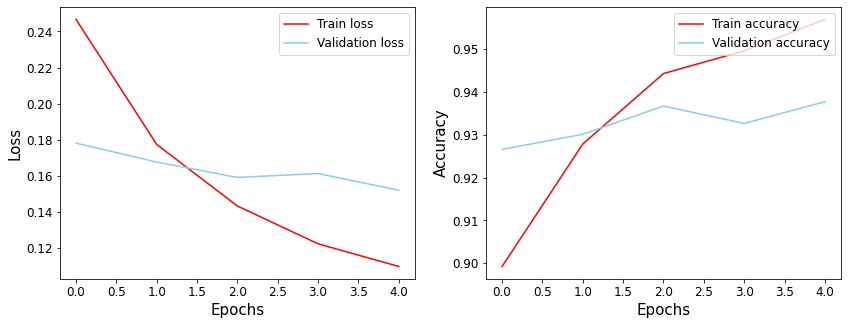

In [22]:
acc_loss(hist1)

In [ ]:
acc1 = net1.evaluate(test_generator)

21/21 [==============================] - 3s 136ms/step - loss: 0.1280 - accuracy: 0.9499


In [23]:
pred_1 = net1.predict(test_generator)

In [24]:
pred_1 = np.argmax(pred_1, axis = 1)

In [25]:
print(classification_report(test_generator.classes, pred_1))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       386
           1       0.96      0.95      0.95       273

    accuracy                           0.96       659
   macro avg       0.96      0.96      0.96       659
weighted avg       0.96      0.96      0.96       659



Text(0.5, 1.0, 'Confusion matrix')

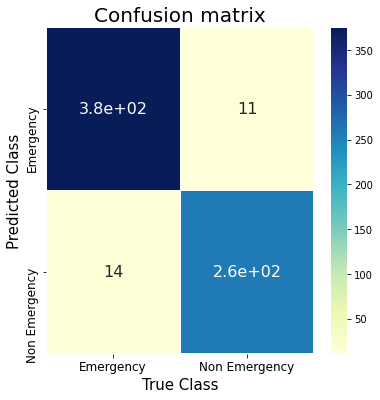

In [26]:
cm = confusion_matrix(test_generator.classes, pred_1)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Emergency', 'Non Emergency']) 
ax.xaxis.set_ticklabels(['Emergency', 'Non Emergency']) 

plt.title("Confusion matrix", size = 20)

## CNN manuale

In [7]:
from keras import layers

In [8]:
model = keras.Sequential(
    [
     keras.Input(shape = (224,224,3)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Flatten(),
     layers.Dense(124, activation = "relu"),
     layers.Dropout(0.5),
     layers.Dense(2, activation = 'softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 124)               5785468   
_________________________________________________________________
dropout (Dropout)            (None, 124)               0

In [9]:
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

histo_best = model.fit(train_generator, 
                       epochs = 3, 
                       batch_size = 128, 
                       validation_data = validation_generator)

Epoch 1/3
124/124 [==============================] - 39s 258ms/step - loss: 0.9654 - accuracy: 0.6303 - val_loss: 0.5977 - val_accuracy: 0.6977
Epoch 2/3
124/124 [==============================] - 27s 214ms/step - loss: 0.5205 - accuracy: 0.7513 - val_loss: 0.5240 - val_accuracy: 0.7468
Epoch 3/3
124/124 [==============================] - 28s 229ms/step - loss: 0.3724 - accuracy: 0.8447 - val_loss: 0.5056 - val_accuracy: 0.7696


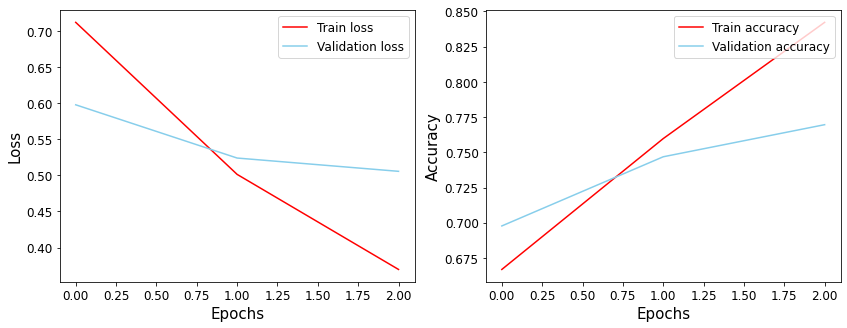

In [12]:
acc_loss(histo_best)

In [14]:
acc_best = model.evaluate(test_generator)

21/21 [==============================] - 317s 16s/step - loss: 0.5570 - accuracy: 0.7527


In [13]:
yc_pred = model.predict(test_generator)
y_pred_best = np.argmax(yc_pred, axis = 1)

In [14]:
print(classification_report(test_generator.classes, y_pred_best))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       386
           1       0.78      0.61      0.68       273

    accuracy                           0.77       659
   macro avg       0.77      0.74      0.75       659
weighted avg       0.77      0.77      0.76       659



Text(0.5, 1.0, 'Confusion matrix')

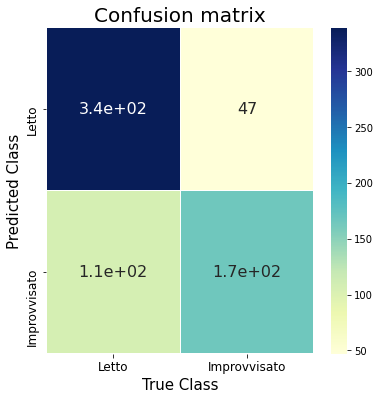

In [15]:
cm = confusion_matrix(test_generator.classes, y_pred_best)
fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 

plt.title("Confusion matrix", size = 20)

## XCEPTION tagliata

In [29]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 3950,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

x_train, y_train = next(train_generator)

Found 3950 images belonging to 2 classes.


In [30]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 1975,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_validation, y_validation = next(validation_generator)

Found 1975 images belonging to 2 classes.


In [31]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 659,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

x_test, y_test = next(validation_generator)

Found 659 images belonging to 2 classes.


In [32]:
base_model = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [33]:
model_1 = keras.Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [34]:
model_1_features = model_1.predict(x_train)
print(model_1_features.shape)

(3950, 14, 14, 728)


In [35]:
model_1_features = model_1_features.reshape((model_1_features.shape[0], 
                                             model_1_features.shape[1]*model_1_features.shape[2]*model_1_features.shape[3]))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_1 = LogisticRegression(solver="lbfgs", multi_class="auto", max_iter=30, penalty ='l2', verbose = 1)
lr_1.fit(model_1_features, tf.argmax(y_train, axis=1))

In [ ]:
y_pred_train_1 = lr_1.predict(model_1_features)

In [ ]:
classification_report_train_1 = classification_report(np.argmax(y_train, axis=1),y_pred_train_1)
print(classification_report_train_1)
classification_report_train_1= classification_report(np.argmax(y_train, axis=1),y_pred_train_1, output_dict=True)
classification_report_train_1 = pd.DataFrame(classification_report_train_1).transpose()

In [ ]:
model_1_validation_features = model_1.predict(x_validation)
model_1_validation_features = model_1_validation_features.reshape(model_1_validation_features.shape[0],
                                                                  model_1_validation_features.shape[1]*model_1_validation_features.shape[2]*model_1_validation_features.shape[3])

In [ ]:
y_pred_validation_1 = lr_1.predict(model_1_validation_features)

In [ ]:
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1)
print(classification_report_validation_1)
classification_report_validation_1= classification_report(np.argmax(y_validation, axis=1),y_pred_validation_1, output_dict=True)
classification_report_validation_1 = pd.DataFrame(classification_report_validation_1).transpose()

In [ ]:
model_1_test_features = model_1.predict(x_test)
model_1_test_features = model_1_test_features.reshape(model_1_test_features.shape[0],
                                                      model_1_test_features.shape[1]*model_1_test_features.shape[2]*model_1_test_features.shape[3])

In [ ]:
y_pred_test_1 = lr_1.predict(model_1_test_features)

In [ ]:
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1)
print(classification_report_test_1)
classification_report_test_1= classification_report(np.argmax(y_test, axis=1),y_pred_test_1, output_dict=True)
classification_report_test_1 = pd.DataFrame(classification_report_test_1).transpose()

# Demo

In [127]:
single_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

single_generator = single_processing.flow_from_directory("gdrive/MyDrive/single",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 8,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

test,label_test = next(single_generator)

Found 8 images belonging to 1 classes.


In [128]:
prova_pred = net1.predict(single_generator)
result = np.argmax(prova_pred, axis = 1)
result

array([1, 0, 1, 1, 1, 0, 0, 1])

In [129]:
labels = (train_generator.class_indices).copy()
labels['Not Emergency'] = labels['class_0']
labels['Emergency'] = labels['class_1']

del labels['class_0']
del labels['class_1']

labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in result]

In [130]:
predictions

['Emergency',
 'Not Emergency',
 'Emergency',
 'Emergency',
 'Emergency',
 'Not Emergency',
 'Not Emergency',
 'Emergency']

La classe 1 è quella dei veicoli di emergenza

In [131]:
prova_pred

array([[0.09320138, 0.9928631 ],
       [0.78175384, 0.757487  ],
       [0.15241091, 0.9383376 ],
       [0.07533869, 0.98778   ],
       [0.7092192 , 0.894524  ],
       [0.9265203 , 0.20975761],
       [0.97900635, 0.38344505],
       [0.30680335, 0.952226  ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predizione: Emergency')

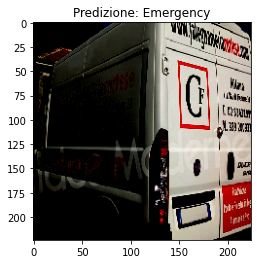

In [132]:
plt.imshow(test[0,:,:,:])
plt.title("Predizione: {}".format(predictions[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


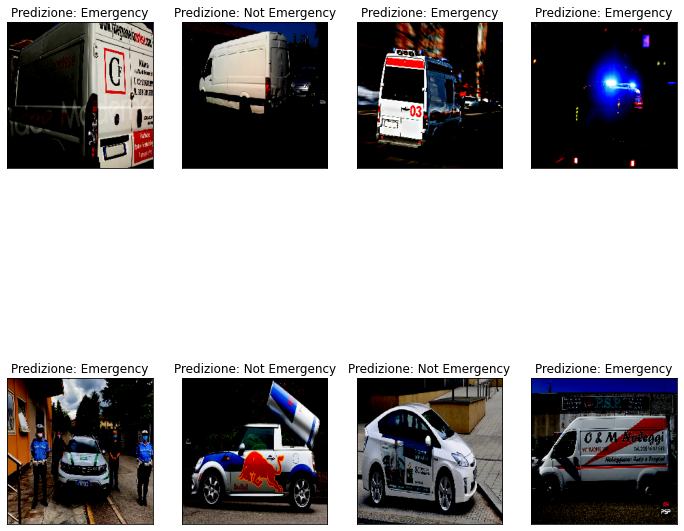

In [146]:
fig = plt.figure(figsize = (12,12))

for i, immagine in enumerate(test):
  fig.add_subplot(2,4,i+1)
  plt.imshow(immagine)
  plt.title("Predizione: {}".format(predictions[i]))
  plt.tick_params(axis='both', which='both', bottom=False, top=False, left = False,
                  right = False, labelbottom=False, labelleft=False)
  